In [ ]:
!pip install langchain langgraph cassio langchain_community tiktoken langchain-groq langchainhub langchain langgraph langchain_huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 M

In [ ]:
import cassio
ASTRADB_TOKEN='AstraCS:fDfaeZUqzOTTFeJduDZXQdHS:0b797ea3a8ffe26455d2c4bad23383c448acea81fb602da8765149ab8a830380'
ASTRADB_ID='de406f36-204a-40ae-8436-bf584ed75622'
cassio.init(token=ASTRADB_TOKEN,database_id=ASTRADB_ID)

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

In [ ]:
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs  for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500)
docs_split = text_splitter.split_documents(docs_list)

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
from dotenv import load_dotenv
load_dotenv()
embedding = HuggingFaceEmbeddings(
    model_name='sentence-transformers/all-MiniLM-L6-v2'
)

In [ ]:
from langchain.vectorstores.cassandra import Cassandra
vector_store=Cassandra(
    embedding=embedding,
    table_name='qa_mini_demo',
    session=None,
    keyspace=None
)

In [ ]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
vector_store.add_documents(docs_split)
vector_index=VectorStoreIndexWrapper(vectorstore=vector_store)

In [ ]:
retriever = vector_store.as_retriever(search_kwargs=dict(k=2))
retriever.invoke('what is agent')

[Document(id='1162ffe53ed446d7a1668e931f60d45d', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

In [ ]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain.pydantic_v1 import BaseModel,Field

class RouteQuery(BaseModel):
  """route a user query to most relavent datasource"""
  datasource:Literal['vectorstore','wiki_search'] = Field(description='given a user question choose route it to vectorstore or wikisearch')

In [ ]:
from langchain_groq import ChatGroq
from google.colab import userdata
groq_api = userdata.get('GROQ_API_KEY')
llm = ChatGroq(model='gemma2-9b-it',api_key=groq_api)

In [ ]:
structured_llm_router =llm.with_structured_output(RouteQuery)

In [ ]:
 system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

In [ ]:
print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='wiki_search'
datasource='vectorstore'


In [ ]:
!pip install arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.6 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=03e7c9c60a0f28a28d28b9a7feacdf2fd6517466be4380fa2da1bcba8ef1d69d
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=dab9a0da8ef6a7565bc8c22132d4e3f60353e9134315d4526f64aa832446e5f6
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built wikipedia sgmllib3k


In [ ]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun
wiki_api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_api_wrapper)
wiki_tool.run('ai')

'Page: Artificial intelligence\nSummary: Artificial intelligence (AI) refers to the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, r'

In [ ]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
  """Represents state of graph. Attributes:
    question:question
    generation:LLM generation
    documents:list of documents
  """
  question:str
  generation:str
  documents:List[str]



In [ ]:
from langchain.schema import Document

def retrieve(state):
  print('---Retrieve---')
  question=state['question']
  # retieval
  documents=retriever.invoke(question)
  return {'documents':documents,'question':question}

def wiki_search(state):
  print('---wiki---')
  question = state['question']
  docs = wiki_tool.invoke({'query':question})
  wiki_results=Document(page_content=docs)
  return {'documnets':wiki_results,'question':question}

def route_question(state):
  print('---route quaetion---')
  question= state['question']
  source=question_router.invoke({'question':question})
  if source.datasource=='wiki_search':
    print('---routed to wiki search---')
    return 'wiki_search'
  if source.datasource=='vectorstore':
    print('--- routed to vector search---')
    return 'vectorstore'

In [ ]:
from langgraph.graph import START,END,StateGraph

workflow=StateGraph(GraphState)

workflow.add_node('wiki_search',wiki_search)
workflow.add_node('retrieve',retrieve)

workflow.add_conditional_edges(
    START,
    route_question,
    {
        'wiki_search':'wiki_search',
        'vectorstore':'retrieve'
    }
)
workflow.add_edge('retrieve',END)
workflow.add_edge('wiki_search',END)

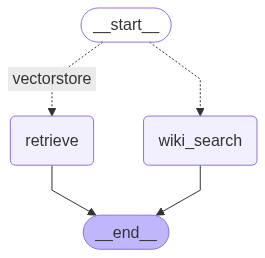

In [ ]:
graph = workflow.compile()
from IPython.display import Image,display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in graph.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---route quaetion---


--- routed to vector search---
---Retrieve---
"Node 'retrieve':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview\n'
 'In a LLM-powered autonomous agent system, LLM functions as the agent’s '
 'brain, complemented by several key components:\n'
 '\n'
 'Planning\n'
 '\n'
 'Subgoal and decomposition: The agent breaks down large tasks into smaller, '
 'manageable subgoals, enabling efficient handling of complex tasks.\n'
 'Reflection and refinement: The agent can do self-criticism and '
 'self-reflection over past actions, learn from mistakes and refine them for '
 'future steps, thereby improving the quality of final results.\n'
 '\n'
 '\

<ipython-input-54-4ffa7e770307>:16: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  pprint(value['documents'][0].dict()['metadata']['description'])


In [ ]:
inputs = {
    "question": "Avengers"
}
for output in graph.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---route quaetion---


--- routed to vector search---
---Retrieve---
"Node 'retrieve':"
'\n---\n'
[Document(id='f3b126f14fb9444ea5ca869b35005d45', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.